## Predictive Modeling:

- Data Cleaning: Ensure there are no missing values or irrelevant features.

- Feature Selection: Use only relevant features for training the model.

- Class Imbalance: Handle class imbalance using techniques like SMOTE.

- Model Training: Train a variety of models (Logistic Regression, Random Forest, XGBoost) and evaluate using appropriate metrics.

- Model Evaluation: Use metrics like ROC AUC, F1-score, MAPE, and cross-validation to evaluate the models.

- Hyperparameter Tuning: Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters.

- Interpretation: Use SHAP to understand which features are most important.

- Reporting: Summarize the model performance and feature importance in a report.

### TASK 1


- Step 1: Start with data cleaning and splitting.

- Step 2: Experiment with different models (Logistic Regression, Random Forest, etc.).

- Step 3: Evaluate the model using metrics and visualizations.

- Step 4: Try hyperparameter tuning to improve performance.

- Step 5: Use SHAP for model interpretation.

- Step 6: Report findings and recommendations.

# End to End model pipeline deployment + MLOps (To make the model publicly accessible for consumption)

STEP 1 
- ETL ---- extract, transform and load the raw data
   i - loaded the raw CSV
   ii - uploaded these CSV to AWS S3 bucket (data lake--- store structured & unstructed data)
   iii - Data modelling ---- define the structure of your data in a database 
     i- Define relationships through primary or secondary keys
     ii - schema design
        - star schema
        - snowflake schema  ----- fact tables & dimensional tables 
          -- fct_patients 
          --- dim_dropout_flag 
          ---- dim_clinics
          ---- dim_home_adherences
          --- dim_feedbacks 

        - define the behavior or your data
          - SCD1 & SCD2 ---- slow changing dimension tables 

    iii - loaded the data to our postgres (well-structured)
    iv - Retrieve our data for use 

STEP 2 
 - Performed Exploratory data analysis (EDA)
   i - data cleaning 
      - missing values 
      - duplicates
      - outliers 
         - IQR 
         - Z-score
   ii - data distribution 
     - Univariate analysis
     - handle skewnesss (eg log transforms)
  iii - Correlation analysis
     - Multivariate analysis
     - checked for relationship between features 

  iv - Problem analysis (Dropout)
    -- exploreeeeee lagrangeeeeeee !!!!!!!

STEP 3 (CLUSTERING)
  - K-means
    - elbow
       - sharp bend --- all k after the sharp means that the more cluster the more insignificant (e.g -- silhoutee reduces)
    - silhoutee  (how well your k is formated e.g how well is the pizza cut)
    - choose your optima K (e.g 2,3)
    - implement k on the algorithm
  - DBSCAN / HBSCAN   
    - Auto-scan 
    - core points
    - border points
    - Outliers 
    - outputs your elbow and silhoutee (Business KPI e.g 0.65---- 0.01)
    - optimzing and productionized the clustering model

STEP 4 (PREDICTION)
???????


BUFFER POINT : tracking - MLFLOW
STEP 5 (DEPLOYMENT + MLOPS)     

1 - Localize stage 1
  i - Implement our Endpoints (FastAPI) - API centric (asynchronouse & Asynchronous)
        - flask - lightweight RESTFUL API - web application & scripts
        - Django - complex -- web development (scalability, more secured)
 ii - make requests locally via:
    - Swagger UI
    - Postman
 iii - Test our endpoints 
     - write test cases
      - pytest
 
2 - Containeralized stage 
   - Dockerfile --- multi-stage
     - yaml file -- markuup language use in writing IAC---(infrastructure as code)
   - Dockercompose - easier way to run your containerrizlied apps
   - secret management -- all your crendentials  (data governance)
      - IAM rules --- role based managements (resources, users,, groups policies(read and write access, upload acces insituation IAC like aws cdK or SAM))
      - aws secrets managament
      - policy management (resources)
      - s3 lake formation (storage RBA--role based access)
    - CI-CD (continious integration & continious development)
      - github actions 
        - step 1 
        - step 2
        - step 3
      - terraform (IAC)
        - provision aws lambda 
        - managed dependencies with versioning

3 - Cloud Stage (AWS)
  - API-- fastAPI- Dockerized- VMachine (linux, ubuntu)-- 
     - EC2 instance 
     - Lambda - serverless resource (pay-as-you-go)
     - Kubernetes cluster
     - API gateway
4 - MLOps ---- (Machine learning operations)
   - EXperiments
   - model registery - hugging face
   - monitoring & tracking - MLFLOW - drift


  



# Project structure 

#### 1 - implement our endpoints using FASTAPI

medoptix-ai/
├── app/
│   ├── main.py                
│   ├── models.py              
│   ├── prediction.py          
│   └── database.py            
├── models/                 
│   ├── clustering_results.pkl
│   ├── medoptix_clustering_*.pkl
│   └── medoptix_prediction_*.pkl
├── tests/
│   ├── test_api.py
│   └── test_prediction.py
├── requirements.txt
├── Dockerfile
├── docker-compose.yml
└── .env

### CLUSTERING PIPELINE

In [9]:
# step 1: Predictions # importing my libraries
import os
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold      import TSNE
import joblib
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
# step 2 

patients = pd.read_csv('C:/Users/Muham/Downloads/EX-ROLES/AMDARI/medoptix-ai-internship/medoptix_data/raw/patients.csv')
sessions = pd.read_csv('C:/Users/Muham/Downloads/EX-ROLES/AMDARI/medoptix-ai-internship/medoptix_data/raw/sessions.csv')
dropout_flag = pd.read_csv('C:/Users/Muham/Downloads/EX-ROLES/AMDARI/medoptix-ai-internship/medoptix_data/raw/dropout_flags.csv')



In [ ]:
# Clustering patients based on their data

#clustering pipeline (moduralized/optimized for production)
class MedOptixClustering:
    def __init__(self):
        self.preproc = None
        self.pca = None
        self.kmeans = None
        self.num_col = None
        self.cat_col = None

    # step 1 - loads our data
    def load_data(self):
        """ loading our data"""
        return patients, sessions, dropout_flag

    #step 2 - Defined the session features
    def create_session_features(self, sessions):
        sess_agg = (
            sessions
            .sort_values(['patient_id', 'date'])    
            .assign(pain_delta=lambda d: d.groupby("patient_id")["pain_level"].diff())
            .groupby("patient_id") 
            .agg (
                n_sessions = ("session_id", "count"),          
                avg_session_duration = ("duration", "mean"),
                first_week = ("week", "min"),
                last_week = ("week", "max"),
                mean_pain = ("pain_level", "mean"),
                mean_pain_delta = ("pain_delta", "mean"),
                home_adherence_mean = ("home_adherence_pc", "mean"),
                satisfaction_mean = ("satisfaction", "mean")
            ))
        return sess_agg

    # step 3 prepare the patient data
    def prepare_patient(self, patients, sessions):
        # combining the patient and session data

        pat_sel = patients[
            [
                "patient_id",
                "age",
                "gender",
                "bmi",
                "smoker",
                "chronic_cond",
                "injury_type",
                "referral_source",
                "insurance_type"
            ]
        ].set_index("patient_id")

        #step 3a : calling session features 
        sess_agg = self.create_session_features(sessions)

        #step 3b : join the patient and session data
        X_raw = (
            pat_sel
            .join(sess_agg, how="left")
            .reset_index()
        )

        return X_raw
    
    # step 4 - define the numerical and categorical columns
    def setup_preprocessing(self):
        """ step 4a : Define the pipelines for numerical and categorical features"""
        self.num_col = [
            "age", "bmi",
            "n_sessions", "avg_session_duration",
            "mean_pain", "mean_pain_delta"
        ]

        self.cat_col = [
            "gender", "smoker",
            "chronic_cond", "injury_type"
        ]

        #step 4b : Define the numerical and categorical pipelines
        numeric_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ])

        # step 4c : Define the categorical pipeline
        categorical_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])

        # step 4d : column transformer
        self.preproc = ColumnTransformer(
            transformers=[
                ("num", numeric_pipe, self.num_col),
                ("cat", categorical_pipe, self.cat_col)
            ])

        return self.preproc


    # step 7 - fit the KMeans model
    def find_optimal_k (self, X_reduced , k_range=range(2,11)):
        """ Find optimal number of clusters using elbow and silhouette methods"""
        wcss, sils = [], []
    
        for k in k_range:                    
            kmeans = KMeans(
                n_clusters= k,
                init = "k-means++",          
                n_init= "auto",
                random_state= 42,
                algorithm = "lloyd",
            )
            preds = kmeans.fit_predict(X_reduced)           
            wcss.append(kmeans.inertia_)            
            sils.append(silhouette_score(X_reduced, preds))
        
        # step 7a : Plot the elbow method
        fig , (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

        ax1.plot(k_range, wcss, marker="o")
        ax1.set_title("Elbow Method")
        ax1.set_xlabel("Number of clusters (k)")
        ax1.set_ylabel("WCSS")

        ax2.plot(k_range, sils, marker="o")
        ax2.set_title("Silhouette Method")
        ax2.set_xlabel("Number of clusters (k)")
        ax2.set_ylabel("Silhouette Score")

        plt.tight_layout()
        plt.show()

        return wcss, sils

    # step 8 - fit the Kmeans model
    def perform_clustering(self, X_raw, k_opt=3):
        """ complete our clustering process"""
        print(f"Performing clustering with k={k_opt}...")

        #step 8a : Preprocessing
        print("Preprocessing data...")
        self.setup_preprocessing()

        # step 8b : Fit the preprocessor (model the data)
        X_clean = self.preproc.fit_transform(X_raw)

        # step 8c : Fit the PCA model for dimensionality reduction
        print("Fitting PCA...")
        self.pca = PCA(n_components=0.95, random_state=42)
        X_reduced = self.pca.fit_transform(X_clean)
        print(f"Reduced data shape: {X_reduced.shape}")

        # step 8d : Find optimal number of clusters
        print("Finding optimal number of clusters...")
        wcss, sils = self.find_optimal_k(X_reduced)

        # step 8e : Final clustering with KMeans
        print("Fitting KMeans...")
        self.kmeans = KMeans(
            n_clusters=k_opt, 
            init="k-means++",
            n_init="auto",
            random_state=42, 
            algorithm="lloyd"
        )
        clusters = self.kmeans.fit_predict(X_reduced)


        # step 8f : Evaluate the clustering 
        sil_score = silhouette_score(X_reduced, clusters)
        print(f"Silhouette Score: {sil_score:.3f}")

        # step 8g : Visualize the clusters
        self.visualize_clusters(X_reduced, clusters)
        return clusters, X_reduced, X_clean
    

    # step 9 - visualize the clusters
    def visualize_clusters(self, X_reduced, clusters):
        """ visualize clusters using PCA AND T-SNE"""
        
        # step 9a : PCA visualization
        pca2  = PCA(n_components=2, random_state=42)
        X_pca2d = pca2.fit_transform(X_reduced)

        # step 9b tsne visualization
        tsne2 = TSNE(n_components=2, perplexity=40,
             init="pca", random_state=42)
        X_tsne2d = tsne2.fit_transform(X_reduced)

        # step 9c plotting the PCA clusters
        fig , (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

        scatter1 = ax1.scatter(X_pca2d[:, 0], X_pca2d[:, 1], c=clusters, cmap="viridis", s=50)
        ax1.set_title("PCA Clusters")
        ax1.set_xlabel("PCA Component 1") 
        ax1.set_ylabel("PCA Component 2")
        plt.colorbar(scatter1, ax=ax1, label="Cluster")

        scatter2 = ax2.scatter(X_tsne2d[:, 0], X_tsne2d[:, 1], c=clusters, cmap="viridis", s=50)
        ax2.set_title("t-SNE Clusters")
        ax2.set_xlabel("t-SNE Component 1")
        ax2.set_ylabel("t-SNE Component 2")
        plt.colorbar(scatter2, ax=ax2, label="Cluster")

        plt.tight_layout()
        plt.show()

    # step 10 save the model
    def save_models(self, filepath_prefix="medoptix_clustering"):
        """ saving our trained model """
        joblib.dump(self.preproc, f"{filepath_prefix}_preproc.pkl")
        joblib.dump(self.pca, f"{filepath_prefix}_pca.pkl")
        joblib.dump(self.kmeans, f"{filepath_prefix}_kmeans.pkl")
        print(f"Models saved with prefix: {filepath_prefix}")

 


Raw data shape: (5000, 17)
feature columns: ['patient_id', 'age', 'gender', 'bmi', 'smoker', 'chronic_cond', 'injury_type', 'referral_source', 'insurance_type', 'n_sessions', 'avg_session_duration', 'first_week', 'last_week', 'mean_pain', 'mean_pain_delta', 'home_adherence_mean', 'satisfaction_mean']
Performing clustering with k=3...
Preprocessing data...
Fitting PCA...
Reduced data shape: (5000, 13)
Finding optimal number of clusters...


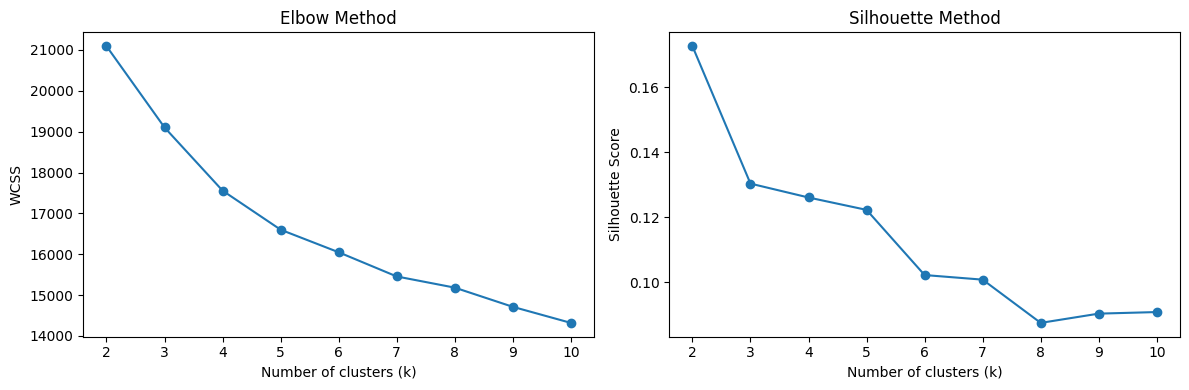

Fitting KMeans...
Silhouette Score: 0.130


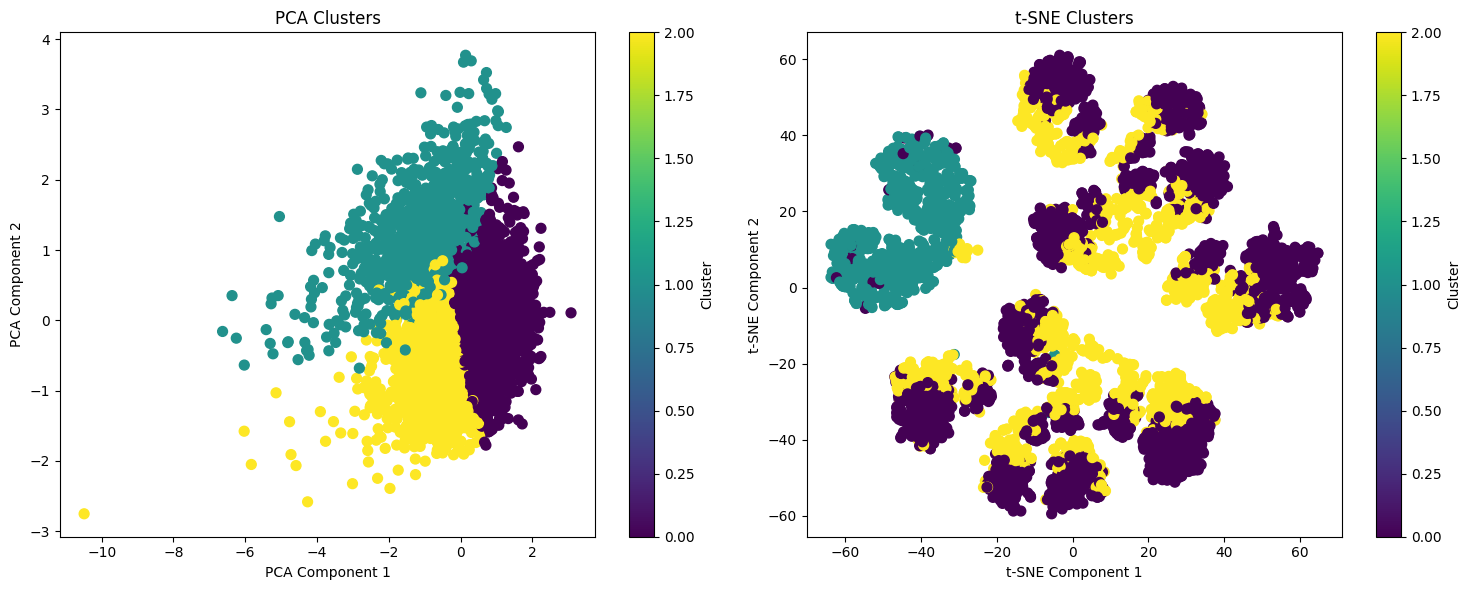

Models saved with prefix: medoptix_clustering
Clustering completed and results saved.
cluster distribution:  0    2634
2    1506
1     860
Name: count, dtype: int64
 file saved as: clustering_results.pkl, medoptix_clustering_*.pkl


In [39]:
# call the classes and methods


if __name__ == "__main__":
    clustering = MedOptixClustering()


    #loading the data
    patients, sessions, dropout_flag = clustering.load_data()

    # prepare features 
    X_raw = clustering.prepare_patient(patients, sessions)
    print(f"Raw data shape: {X_raw.shape}")
    print(f"feature columns: {X_raw.columns.tolist()}")

    # step 4 : perform clustering
    clusters, X_reduced, X_clean = clustering.perform_clustering(X_raw, k_opt=3)

    #create labels
    label = dropout_flag.set_index("patient_id")["dropout"]


    # save results for prediction 

    results = {
        'X_raw' : X_raw,
        "clusters": clusters,
        'label': label,
        "X_reduced": X_reduced,
        "X_clean": X_clean
    }

    joblib.dump(results, "medoptix_clustering_results.pkl")

    #save the model
    clustering.save_models()


    print("Clustering completed and results saved.")
    print("cluster distribution: ", pd.Series(clusters).value_counts())
    print(f" file saved as: clustering_results.pkl, medoptix_clustering_*.pkl")

### 2 - PREDICTION PIPELINE 

In [ ]:
# prediction pipeline

# dropout (we want to see those that are likely going to dropout)


class MedOptixPrediction:
    # initialize the class
    def __init__(self):

        self.preproc = None
        self.model = None
        self.num_col = None
        self.cat_col = None


    # step 1 - load the data
    def load_data(self):
        """ loading our data"""
        return patients, sessions, dropout_flag
    
    # step 2 - feature engineering (created session features) aka (BEHAVIORAL FEATURES)
    def create_session_features(self, sessions):
        sess_agg = (
            sessions
            .sort_values(['patient_id', 'date'])    
            .assign(pain_delta=lambda d: d.groupby("patient_id")["pain_level"].diff())
            .groupby("patient_id") 
            .agg (
                n_sessions = ("session_id", "count"),          
                avg_session_duration = ("duration", "mean"),
                first_week = ("week", "min"),
                last_week = ("week", "max"),
                mean_pain = ("pain_level", "mean"),
                mean_pain_delta = ("pain_delta", "mean"),
                home_adherence_mean = ("home_adherence_pc", "mean"),
                satisfaction_mean = ("satisfaction", "mean")
            ))
        return sess_agg
    
    # STEP 3 - prepare the patient data
    def prepare_patient(self, patients, sessions):
        """ prepare the patient data for prediction """
        
        # step 3a selected the most important features from the patient data
        pat_sel = patients[
                [
                    "patient_id",
                    "age",
                    "gender",
                    "bmi",
                    "smoker",
                    "chronic_cond",
                    "injury_type",
                    "referral_source",
                    "insurance_type"
                ]
            ].set_index("patient_id")
    
        # step 3b : calling session features
        sess = self.create_session_features(sessions)

        # step 3 c : join the patient and session data
        X_raw = (
            pat_sel
            .join(sess, how="left")
        ).reset_index()
        
        return X_raw


    # step 4 - define the numerical and categorical columsn 
    def setup_preprocessing(self):
        """ step 4a : Define the pipelines for numerical and categorical features"""
        self.num_col = [
            "age",
            "bmi",
            "n_sessions", 
            "avg_session_duration",
            "mean_pain", 
            "mean_pain_delta"
        ]

        self.cat_col = [
            "gender",
            "smoker",
            "chronic_cond", 
            "injury_type"
        ]

        # step 4b : Define the numerical and categorical pipelines

        numeric_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ])

        # step 4c : Define the categorical pipeline
        categorical_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])

        # step 4d : column transformer
        self.preproc = ColumnTransformer(
            transformers=[
                ("num", numeric_pipe, self.num_col),
                ("cat", categorical_pipe, self.cat_col)
            ])

        return self.preproc
        
    # step 5 : Training the prediction model
    # step 5a : fit the preprocessor 
    def train_model(self, X_raw,y):

        # step 5a : fit the preprocessor
        self.setup_preprocessing()
        X_clean = self.preproc.fit_transform(X_raw)

        # step 5b : train the model
        # 1 - logistic regression
        # 2 - XGboost
        # 3 - Random Forest

        # ALGORITHM 1 - random forest model
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            class_weight='balanced'
        )
        self.model.fit(X_clean, y)

        # step 5 c : shap to explain the model
        self.shap_explainer = shap.TreeExplainer(self.model)
        print("Model trained and explained with SHAP.")


        # # ALGORITHM 2 - XGBoost model
        # ALGORITHM 3 - Logistic Regression model

    # step 6 - Evaluate the model
    def evaluate_model(self, X_raw, y):
        """ classification report and confusion matrix"""

        # step 6a : transformaing the dat using preprocessor
        X_clean  = self.preproc.transform(X_raw)
        preds = self.model.predict(X_clean)
        
        # step 6b : classification report
        print("classification report:\n", classification_report(y, preds))

    
    # step 7 - Predict and explain the model
    def predict(self, X_new):
        """ this helps us t predict the dropout flag"""
        # to be able to return the original rows + drop_probability + shap explanation

        # step 7a : transform the data using preprocessor
        X_clean = self.preproc.transform(X_new)

        # step 7b :  probability of dropout
        dropout_prob = self.model.predict_proba(X_clean)[:,1]
        
        # step 7c : SHAP explainer 
        shap_raw = self.shap_explainer.shap_values(X_clean)

        # step 7d : get the feature names
        features = self.preproc.get_feature_names_out()
        shap_df = pd.DataFrame(shap_raw, columns=features)

        # step 7e : assemble the results
        results = X_new.reset_index()
        results['dropout_probability'] = dropout_prob
        results = pd.concat([results, shap_df], axis=1)

        return results
    

    # step 8 - save the model
    def save_models(self, filepath_prefix="medoptix_prediction"):
        """ saving our trained model """
        joblib.dump(self.preproc, f"{filepath_prefix}_preproc.pkl")
        joblib.dump(self.model, f"{filepath_prefix}_model.pkl")
        print(f"Models saved with prefix: {filepath_prefix}")
        print("Preprocessor and model saved successfully.")



In [15]:
if __name__ == "__main__":
    predictor = MedOptixPrediction()

    #loading the data
    patients, sessions, dropout_flag = predictor.load_data()

    # prepare the features
    X_all = predictor.prepare_patient(patients, sessions)

    # define our target variables (y)
    y_all = dropout_flag.set_index("patient_id")["dropout"]

    # train the model
    predictor.train_model(X_all, y_all)

    # evaluate the model
    predictor.evaluate_model(X_all, y_all)

    # save the model
    predictor.save_models()


Model trained and explained with SHAP.
classification report:
               precision    recall  f1-score   support

       False       1.00      0.92      0.96      4919
        True       0.16      0.84      0.26        81

    accuracy                           0.92      5000
   macro avg       0.58      0.88      0.61      5000
weighted avg       0.98      0.92      0.95      5000

Models saved with prefix: medoptix_prediction
Preprocessor and model saved successfully.
